# validation.ipynb

Validation implementation.

Author: Connacher Murphy

In [1]:
# Libraries
import pest_classification as pest

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.model_selection import StratifiedKFold
import timm
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [2]:
# Use a super small sample for quick testing
quickly = True

In [3]:
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    # PyTorch seed
    torch.manual_seed(seed)
    
    # CUDA 1 GPU seed
    torch.cuda.manual_seed(seed)
    
    # CUDA multi-GPU seed
    torch.cuda.manual_seed_all(seed)
    
    # Force deterministic operations in cudnn
    torch.backends.cudnn.deterministic = True 
    
    # Disable cudnn auto-tuner
    torch.backends.cudnn.benchmark = False

In [4]:
# Set random seed
set_seed(123)

In [5]:
# Configuration
config = SimpleNamespace(**{})

# Grab training observations from images df
# CM: sampling to speed up execution
df_all = pest.df

if quickly:  # select small sample
    config.total_size = 256
    config.batch_size = 32
    config.num_epochs = 2
else:  # "full" sample
    config.total_size = 2048
    config.batch_size = 64
    config.num_epochs = 4

df = df_all[df_all["set"] == "train_set"].sample(config.total_size)
df = df.reset_index(drop=True)

In [6]:
# Dataset and dataloader
config.image_dir = os.path.expanduser("~/data/ccmt/CCMT Dataset-Augmented")
config.image_size = 256

In [7]:
# Add folds to the dataframe
config.n_folds = 4

skf = StratifiedKFold(n_splits=config.n_folds)
# CM: should I add a shuffle here?
# skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True)

In [8]:
# Partition into folds
for fold, (train_index, val_index) in enumerate(skf.split(df, df.label)):
    df.loc[val_index, "fold"] = fold

In [9]:
# Specify architecture parameters
config.num_classes = len(pest.crop_descriptions["Maize"])
# config.num_classes = 2
config.backbone = "resnet18"

# Specify optimizer parameters
config.lr = 1e-4

In [10]:
# Select GPU if available
print(torch.cuda.is_available())
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [11]:
# Training function
def train(train_dataloader, valid_dataloader, model, optimizer, config):
    train_loss_history = []
    train_accuracy_history = []
    valid_loss_history = []
    valid_accuracy_history = []

    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch + 1}")
        print("Training...")
        model, train_loss, train_accuracy, train_tab = pest.train_epoch(
            train_dataloader, model, optimizer, config
        )

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        train_tab_sum = np.sum(train_tab, axis=1, keepdims=True)

        print(f"Training: loss = {train_loss}, accuracy = {train_accuracy}")
        print("Label versus predicted label tabulation:")
        print(np.round(train_tab / train_tab_sum, 2))
        print(train_tab_sum)
        print("\n")

        print("Validating...")
        valid_loss, valid_accuracy, valid_tab = pest.validate_epoch(
            valid_dataloader, model, config
        )

        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)

        valid_tab_sum = np.sum(train_tab, axis=1, keepdims=True)

        print(f"Validation: loss = {valid_loss}, accuracy = {valid_accuracy}")
        print("Label versus predicted label tabulation:")
        print(np.round(valid_tab / valid_tab_sum, 2))
        print(valid_tab_sum)
        print("\n")

    return (
        train_loss_history,
        train_accuracy_history,
        valid_loss_history,
        valid_accuracy_history,
    )

Fold 0
Epoch 1
Training...


100%|██████████| 6/6 [00:19<00:00,  3.24s/it]


Training: loss = 1.9485508402188618, accuracy = 0.18229166666666666
Label versus predicted label tabulation:
[[0.1  0.   0.2  0.   0.2  0.5  0.  ]
 [0.43 0.23 0.07 0.   0.23 0.03 0.  ]
 [0.   0.12 0.25 0.   0.62 0.   0.  ]
 [0.11 0.09 0.09 0.   0.54 0.14 0.03]
 [0.23 0.03 0.18 0.   0.44 0.13 0.  ]
 [0.11 0.04 0.18 0.   0.39 0.21 0.07]
 [0.14 0.1  0.07 0.02 0.36 0.26 0.05]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [39.]
 [28.]
 [42.]]


Validating...


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Validation: loss = 1.9479604959487915, accuracy = 0.15625
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.2  0.1  0.  ]
 [0.07 0.03 0.   0.   0.   0.23 0.  ]
 [0.   0.   0.12 0.   0.12 0.12 0.  ]
 [0.   0.03 0.   0.   0.06 0.2  0.03]
 [0.   0.   0.   0.   0.1  0.21 0.  ]
 [0.   0.   0.   0.   0.21 0.14 0.  ]
 [0.   0.05 0.07 0.   0.   0.24 0.  ]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [39.]
 [28.]
 [42.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:17<00:00,  2.97s/it]


Training: loss = 1.8723663489023845, accuracy = 0.3385416666666667
Label versus predicted label tabulation:
[[0.3  0.   0.1  0.   0.2  0.4  0.  ]
 [0.13 0.47 0.03 0.   0.3  0.07 0.  ]
 [0.   0.   0.12 0.   0.62 0.12 0.12]
 [0.09 0.09 0.06 0.03 0.66 0.06 0.03]
 [0.05 0.03 0.   0.   0.85 0.08 0.  ]
 [0.   0.04 0.11 0.   0.46 0.32 0.07]
 [0.05 0.07 0.02 0.02 0.57 0.17 0.1 ]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [39.]
 [28.]
 [42.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

Validation: loss = 1.9010887742042542, accuracy = 0.265625
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.2  0.1  0.  ]
 [0.   0.1  0.   0.   0.1  0.13 0.  ]
 [0.   0.   0.   0.   0.25 0.   0.12]
 [0.03 0.   0.   0.   0.09 0.14 0.06]
 [0.   0.   0.03 0.   0.21 0.03 0.05]
 [0.   0.   0.   0.   0.21 0.14 0.  ]
 [0.02 0.05 0.07 0.   0.07 0.1  0.05]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [39.]
 [28.]
 [42.]]




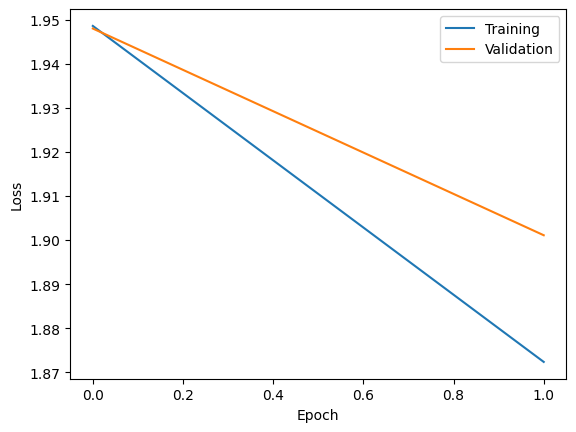

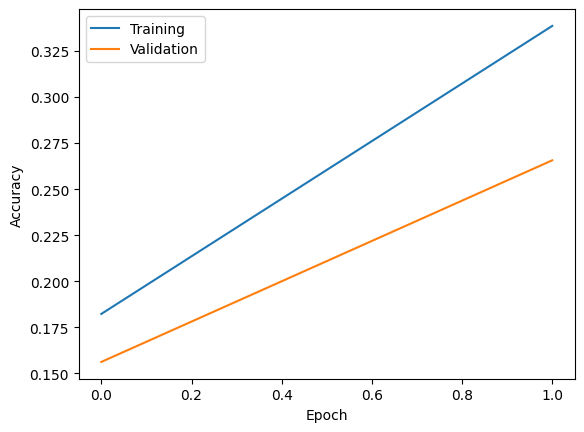



Fold 1
Epoch 1
Training...


100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


Training: loss = 1.92127525806427, accuracy = 0.20833333333333334
Label versus predicted label tabulation:
[[0.1  0.1  0.   0.   0.3  0.3  0.2 ]
 [0.   0.17 0.1  0.   0.3  0.4  0.03]
 [0.   0.12 0.   0.   0.   0.75 0.12]
 [0.   0.11 0.06 0.06 0.14 0.34 0.29]
 [0.11 0.03 0.   0.05 0.08 0.58 0.16]
 [0.11 0.04 0.   0.11 0.14 0.5  0.11]
 [0.09 0.02 0.02 0.   0.05 0.47 0.35]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [38.]
 [28.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Validation: loss = 1.9017115235328674, accuracy = 0.28125
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.2  0.1  0.  ]
 [0.   0.03 0.   0.   0.17 0.07 0.07]
 [0.   0.   0.   0.   0.12 0.12 0.12]
 [0.   0.03 0.03 0.   0.17 0.03 0.06]
 [0.   0.   0.   0.   0.11 0.05 0.18]
 [0.   0.04 0.   0.   0.11 0.07 0.14]
 [0.   0.02 0.   0.   0.02 0.02 0.26]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [38.]
 [28.]
 [43.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:17<00:00,  2.93s/it]


Training: loss = 1.8377890586853027, accuracy = 0.4166666666666667
Label versus predicted label tabulation:
[[0.1  0.1  0.   0.   0.4  0.2  0.2 ]
 [0.   0.3  0.03 0.   0.2  0.3  0.17]
 [0.   0.12 0.   0.   0.12 0.5  0.25]
 [0.   0.06 0.03 0.17 0.14 0.29 0.31]
 [0.03 0.03 0.03 0.05 0.55 0.18 0.13]
 [0.04 0.04 0.   0.   0.18 0.5  0.25]
 [0.   0.   0.   0.   0.05 0.28 0.67]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [38.]
 [28.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

Validation: loss = 1.8594605922698975, accuracy = 0.40625
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.2  0.1  0.  ]
 [0.   0.1  0.   0.   0.13 0.   0.1 ]
 [0.   0.   0.   0.   0.25 0.12 0.  ]
 [0.   0.03 0.   0.   0.2  0.03 0.06]
 [0.   0.   0.   0.   0.21 0.03 0.11]
 [0.   0.   0.   0.   0.11 0.11 0.14]
 [0.   0.02 0.   0.   0.02 0.   0.28]]
[[10.]
 [30.]
 [ 8.]
 [35.]
 [38.]
 [28.]
 [43.]]




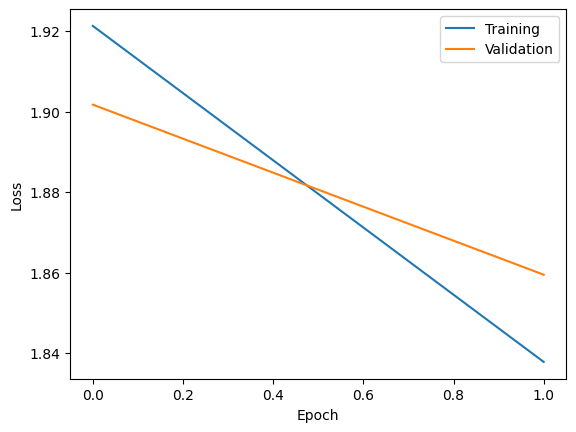

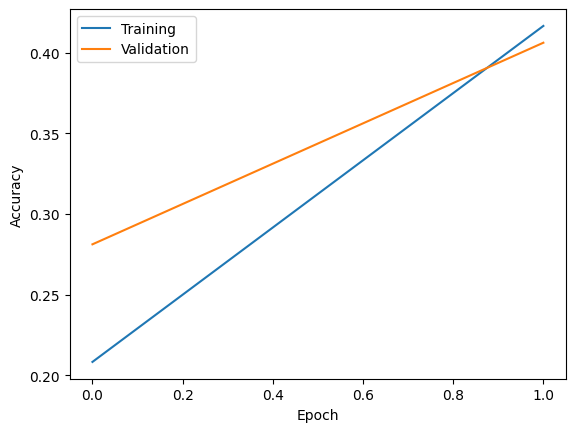



Fold 2
Epoch 1
Training...


100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


Training: loss = 1.9241932034492493, accuracy = 0.2604166666666667
Label versus predicted label tabulation:
[[0.22 0.   0.   0.11 0.   0.   0.67]
 [0.17 0.03 0.   0.13 0.13 0.   0.53]
 [0.   0.   0.   0.   0.11 0.   0.89]
 [0.06 0.   0.   0.32 0.03 0.   0.59]
 [0.08 0.   0.   0.13 0.05 0.   0.74]
 [0.07 0.03 0.   0.03 0.14 0.   0.72]
 [0.14 0.   0.   0.   0.07 0.   0.79]]
[[ 9.]
 [30.]
 [ 9.]
 [34.]
 [38.]
 [29.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Validation: loss = 1.8817474842071533, accuracy = 0.28125
Label versus predicted label tabulation:
[[0.33 0.   0.   0.11 0.   0.   0.  ]
 [0.   0.   0.   0.17 0.   0.   0.17]
 [0.   0.   0.   0.   0.   0.   0.22]
 [0.   0.   0.   0.15 0.03 0.   0.18]
 [0.   0.03 0.   0.05 0.03 0.   0.24]
 [0.07 0.   0.   0.07 0.   0.   0.17]
 [0.07 0.   0.   0.05 0.   0.   0.21]]
[[ 9.]
 [30.]
 [ 9.]
 [34.]
 [38.]
 [29.]
 [43.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:17<00:00,  2.90s/it]


Training: loss = 1.8500147461891174, accuracy = 0.296875
Label versus predicted label tabulation:
[[0.11 0.   0.   0.11 0.11 0.   0.67]
 [0.   0.03 0.   0.2  0.07 0.   0.7 ]
 [0.   0.   0.   0.   0.11 0.   0.89]
 [0.06 0.03 0.   0.44 0.03 0.   0.44]
 [0.   0.   0.   0.   0.03 0.   0.97]
 [0.1  0.07 0.   0.03 0.1  0.   0.69]
 [0.02 0.   0.   0.02 0.05 0.   0.91]]
[[ 9.]
 [30.]
 [ 9.]
 [34.]
 [38.]
 [29.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]

Validation: loss = 1.8657820224761963, accuracy = 0.25
Label versus predicted label tabulation:
[[0.   0.   0.   0.   0.   0.   0.44]
 [0.   0.   0.   0.1  0.   0.   0.23]
 [0.   0.   0.   0.   0.   0.   0.22]
 [0.   0.   0.   0.09 0.06 0.   0.21]
 [0.   0.03 0.   0.03 0.   0.   0.29]
 [0.   0.   0.   0.03 0.   0.   0.28]
 [0.02 0.   0.   0.   0.   0.   0.3 ]]
[[ 9.]
 [30.]
 [ 9.]
 [34.]
 [38.]
 [29.]
 [43.]]




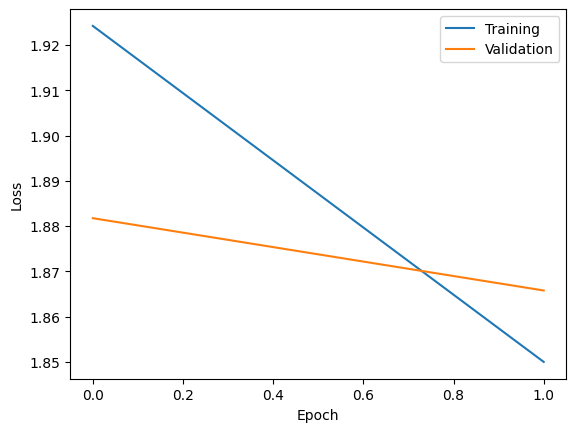

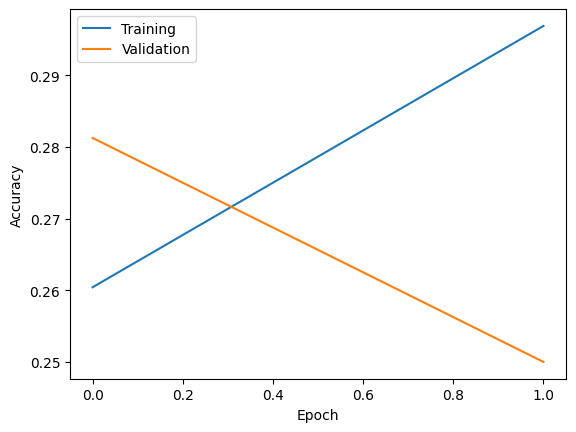



Fold 3
Epoch 1
Training...


100%|██████████| 6/6 [00:18<00:00,  3.15s/it]


Training: loss = 1.939614176750183, accuracy = 0.15104166666666666
Label versus predicted label tabulation:
[[0.   0.2  0.   0.   0.3  0.5  0.  ]
 [0.07 0.07 0.03 0.07 0.23 0.43 0.1 ]
 [0.   0.38 0.   0.   0.25 0.25 0.12]
 [0.   0.12 0.06 0.   0.53 0.26 0.03]
 [0.05 0.08 0.03 0.   0.47 0.34 0.03]
 [0.03 0.07 0.   0.07 0.62 0.21 0.  ]
 [0.07 0.09 0.07 0.05 0.3  0.35 0.07]]
[[10.]
 [30.]
 [ 8.]
 [34.]
 [38.]
 [29.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Validation: loss = 1.900503695011139, accuracy = 0.28125
Label versus predicted label tabulation:
[[0.   0.2  0.   0.   0.   0.1  0.  ]
 [0.   0.1  0.   0.07 0.07 0.07 0.03]
 [0.   0.12 0.   0.   0.12 0.   0.12]
 [0.   0.09 0.   0.12 0.09 0.03 0.03]
 [0.05 0.05 0.   0.   0.16 0.08 0.  ]
 [0.03 0.03 0.   0.   0.14 0.1  0.  ]
 [0.07 0.   0.   0.   0.19 0.02 0.05]]
[[10.]
 [30.]
 [ 8.]
 [34.]
 [38.]
 [29.]
 [43.]]


Epoch 2
Training...


100%|██████████| 6/6 [00:18<00:00,  3.05s/it]


Training: loss = 1.8733991185824077, accuracy = 0.28125
Label versus predicted label tabulation:
[[0.   0.1  0.   0.1  0.3  0.5  0.  ]
 [0.   0.23 0.03 0.13 0.13 0.33 0.13]
 [0.   0.38 0.   0.   0.25 0.38 0.  ]
 [0.   0.09 0.03 0.12 0.47 0.18 0.12]
 [0.   0.05 0.   0.   0.61 0.29 0.05]
 [0.   0.   0.   0.   0.59 0.38 0.03]
 [0.05 0.14 0.07 0.02 0.23 0.28 0.21]]
[[10.]
 [30.]
 [ 8.]
 [34.]
 [38.]
 [29.]
 [43.]]


Validating...


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]

Validation: loss = 1.882756531238556, accuracy = 0.3125
Label versus predicted label tabulation:
[[0.   0.2  0.   0.   0.   0.1  0.  ]
 [0.   0.13 0.   0.03 0.07 0.07 0.03]
 [0.   0.12 0.   0.   0.12 0.   0.12]
 [0.   0.06 0.   0.09 0.12 0.03 0.06]
 [0.   0.08 0.   0.   0.21 0.05 0.  ]
 [0.03 0.03 0.   0.   0.14 0.1  0.  ]
 [0.02 0.02 0.   0.   0.16 0.07 0.05]]
[[10.]
 [30.]
 [ 8.]
 [34.]
 [38.]
 [29.]
 [43.]]




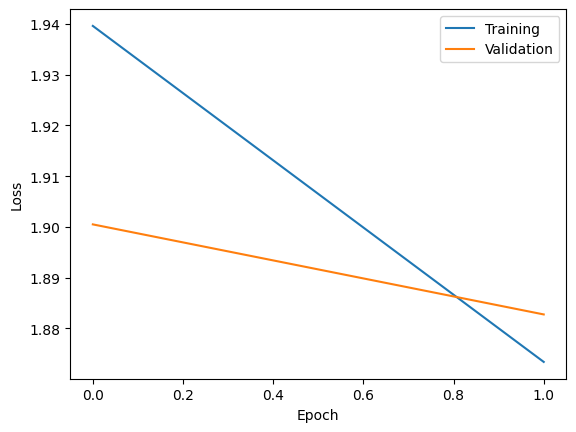

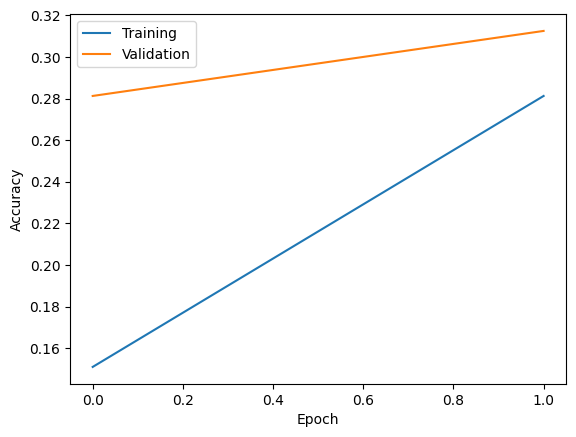

In [12]:
for fold in range(config.n_folds):
    print(f"Fold {fold}")

    # Split into training and validation sets
    train_df = df[df["fold"] != fold].reset_index(drop=True)
    valid_df = df[df["fold"] == fold].reset_index(drop=True)

    train_dataset = pest.AugmentedCCMT(config, train_df)
    valid_dataset = pest.AugmentedCCMT(config, valid_df)

    # Dataloaders
    train_dataloader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0
    )
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0
    )

    # Initialize (pre-trained) model
    model = timm.create_model(
        config.backbone, pretrained=True, num_classes=config.num_classes
    )
    model.to(config.device)

    # Specify loss function (CM: move this to outer loop?)
    config.criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=0.0)

    # Call training function
    (
        train_loss_history,
        train_accuracy_history,
        valid_loss_history,
        valid_accuracy_history,
    ) = train(train_dataloader, valid_dataloader, model, optimizer, config)

    plt.plot(train_loss_history, label = "Training")
    plt.plot(valid_loss_history, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_accuracy_history, label = "Training")
    plt.plot(valid_accuracy_history, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("\n")